# Burgers' Equation

In [1]:
import jax
import jax.numpy as jnp

import optax
from flax import linen as nn

import sys
import os

import time

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../../../../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN
from PIKAN import *

import numpy as np

import matplotlib.pyplot as plt

### Collocation Points

In [2]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([0,1]), N)) # (64, 2)
BC1_data = - jnp.sin(np.pi*BC1_colloc[:,1]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

### Loss Function

In [3]:
def pde_loss(params, collocs, state):
    # Eq. parameter
    v = jnp.array(0.01/jnp.pi, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)  # 1st order derivative of t
    u_x = gradf(u, 1, 1)  # 1st order derivative of x
    u_xx = gradf(u, 1, 2) # 2nd order derivative of x
    
    # Residual
    pde_res = u_t(collocs) + u(collocs)*u_x(collocs) - v*u_xx(collocs)
    
    return pde_res

### Training Baseline

In [4]:
# Initialize model
layer_dims = [2, 8, 8, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(jax.random.PRNGKey(0), jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0}

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

In [5]:
num_epochs = 100000

model, variables, train_losses = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=False, loc_w=None, nesterov=False, 
                                             num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=[], 
                                             colloc_adapt={'epochs' : []})

Epoch 0: Performing grid update
Total Time: 521.1513569355011 s
Average time per iteration: 0.0052 s


In [6]:
# Draw reference values
ref = np.load('../../External Data/Burgers.npz')

N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output, _ = model.apply(variables, jnp.array(coords))
baseline = np.array(output).reshape(N_t, N_x)

l2err = jnp.linalg.norm(baseline-ref['usol'].T)/jnp.linalg.norm(ref['usol'].T)
print(f"L^2 Error = {l2err*100:.4f}%")

L^2 Error = 13.5037%


In [7]:
np.savez('../../Plots/data/eq3-base.npz', t=t, x=x, baseline=baseline, ref=ref['usol'])

### Training Adaptive

In [8]:
# Initialize model
layer_dims = [2, 8, 8, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(jax.random.PRNGKey(0), jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0, 8_000 : 0.7, 20_000 : 0.7, 25_000 : 0.7, 50_000 : 0.8, 75_000 : 0.8, 85_000 : 0.6}

# Define epochs for grid adaptation
adapt_every = 300
adapt_stop = 75000
grid_adapt = [i * adapt_every for i in range(1, (adapt_stop // adapt_every) + 1)]

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3, 8000 : 8, 20_000 : 14}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

# Initialize RBA weights
loc_w = [jnp.ones((collocs.shape[0],1)), jnp.ones((BC1_colloc.shape[0],1)),
         jnp.ones((BC2_colloc.shape[0],1)), jnp.ones((BC3_colloc.shape[0],1))]

# Perform adaptive collocation point sampling
colloc_adapt = dict({'M' : 2**17, 'k' : jnp.array(1.0, dtype=float), 'c' : jnp.array(1.0, dtype=float)})
colloc_adapt['epochs'] = [50_000, 75_000]

In [9]:
num_epochs = 100000

model, variables, train_losses2 = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=True, loc_w=loc_w, nesterov=True, 
                                             num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=grid_adapt, 
                                             colloc_adapt=colloc_adapt)

Epoch 0: Performing grid update
Epoch 8000: Performing grid update
Epoch 20000: Performing grid update
Total Time: 1411.4006035327911 s
Average time per iteration: 0.0141 s


In [10]:
# Draw reference values
ref = np.load('../../External Data/Burgers.npz')

N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output, _ = model.apply(variables, jnp.array(coords))
adaptive = np.array(output).reshape(N_t, N_x)

l2err = jnp.linalg.norm(adaptive-ref['usol'].T)/jnp.linalg.norm(ref['usol'].T)
print(f"L^2 Error = {l2err*100:.4f}%")

L^2 Error = 2.4296%


### Final Results

In [11]:
tabulate_fn = nn.tabulate(model, jax.random.PRNGKey(11))

table = tabulate_fn(collocs)
print(table)


                                  KAN Summary                                   
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs      ┃ outputs     ┃ state       ┃ params       ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│          │ KAN      │ float32[40… │ -           │             │ bias_0:      │
│          │          │             │ float32[40… │             │ float32[8]   │
│          │          │             │ - -         │             │ bias_1:      │
│          │          │             │ float32[8,… │             │ float32[8]   │
│          │          │             │   -         │             │ bias_2:      │
│          │          │             │ float32[8,… │             │ float32[1]   │
│          │          │             │   -         │             │              │
│          │          │             │ float32[1,… │             │ 17 (68 B)    │
├──────────┼──────────┼────

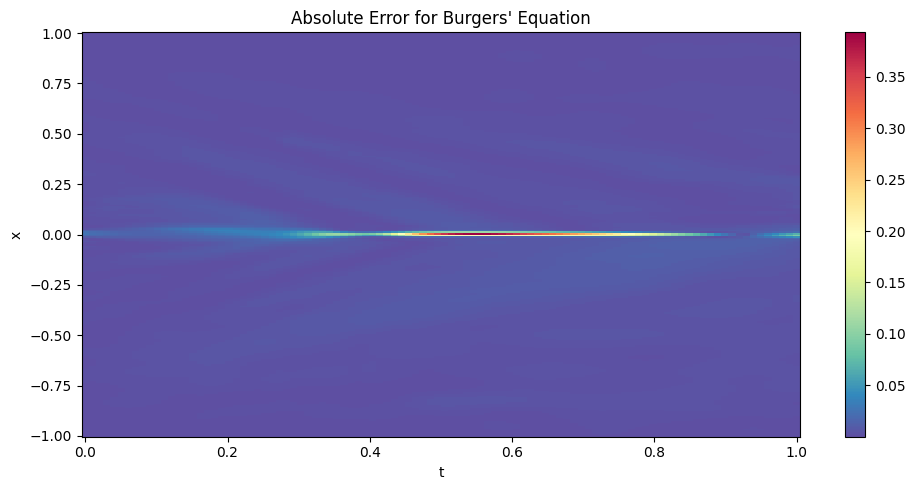

In [12]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(T, X, np.abs(ref['usol'].T-adaptive), shading='auto', cmap='Spectral_r') #
plt.colorbar()

plt.title("Absolute Error for Burgers' Equation")
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

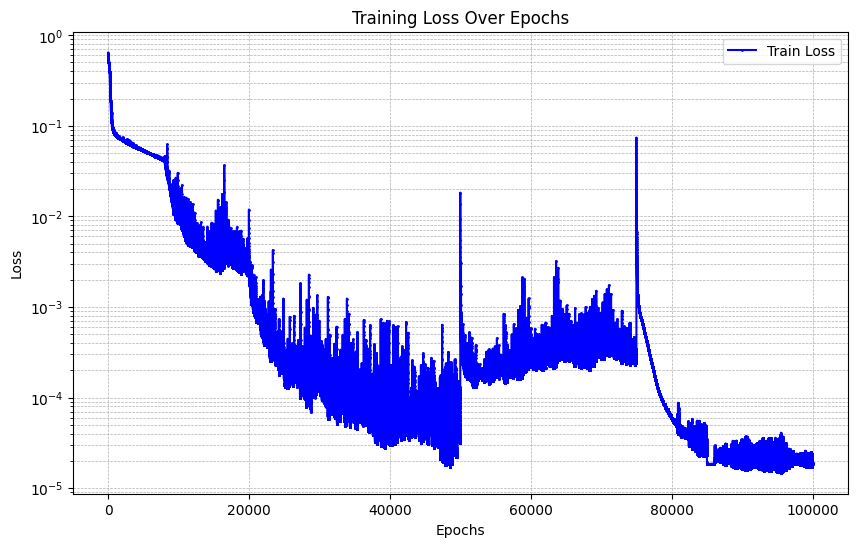

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(train_losses2), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

In [14]:
np.savez('../../Plots/data/eq3-adapt.npz', t=t, x=x, adaptive=adaptive, ref=ref['usol'])